# 객담도말 결핵진단 딥러닝 모델 테스트 결과 보고서 생성

딥러닝 모델 결과 파일과 테스트 데이터셋 메타 정보를 이용하여 보고서를 생성합니다.

In [1]:
#import

import numpy as np
import sys
from sklearn.metrics import roc_curve, auc

%matplotlib notebook

import matplotlib.pyplot as plt

In [2]:
# configuraiton

MODEL_NAME = 'tb_cnn'
#MODEL_NAME = 'tb_vgglike'

FALSE_DECISION_THRESHOLD = 2

TEST_META_FILE_PATH = './dataset/test_meta_64x64_gray_15873.txt'
TEST_RESULT_FILE_PATH = './output/' + MODEL_NAME + '_test_result.txt'
TEST_META_RESULT_MATCH_FILE_PATH = './output/' + MODEL_NAME + '_test_meta_result_match.txt'
TEST_REPORT_FILE_PATH = './output/' + MODEL_NAME + '_test_report.txt'

In [44]:
def tb_roc(test_meta_result_match_line, threshold):
    
    test_report_file = open(TEST_REPORT_FILE_PATH, "at")
    
    test_report_file.write('\n[Threshold :' + str(threshold)+']\n')
    
    test_report_file.write('M = man, D is deep learning model, SD_ID is slide id.\n')
    test_report_file.write('M_DECISION SD_ID MF_DF MF_DT MT_DT MT_DF D_DECISION\n')
    contents_start_flag = False

    prev_slide_id = '-1'
    curr_slide_id = '0'
    slide_decision = ''

    negative_negative = 0
    negative_positive = 0
    positive_negative = 0
    positive_positive = 0

    slide_result_decision = ''
    
    for test_meta_result_match_line in test_meta_result_match_lines:

        if contents_start_flag == False:
            contents_start_flag = True
            continue

        values = test_meta_result_match_line.rstrip().split("\t")

        # Slide P/N	Slide No.	Filename	Index	Object P/N 	predict
        # negative	26	Image_159	0	false 	0
        # negative	26	Image_159	1	false 	1
        # 0             1    2                  3   4         5

        for val_idx in range(len(values)):
            values[val_idx] = values[val_idx].strip()

        curr_slide_id = values[1]

        if not prev_slide_id == curr_slide_id:
            if not prev_slide_id == '-1':

                slide_result_decision = 'negative'
                if (false_true + true_true) > FALSE_DECISION_THRESHOLD:
                    slide_result_decision = 'positive'

                test_report_file.write('%10s %5s %5d %5d %5d %5d %10s'%(slide_decision, prev_slide_id, false_false, false_true, true_true, true_false, slide_result_decision) +'\n')

                if (slide_decision == 'negative' and slide_result_decision == 'negative'):
                    negative_negative = negative_negative + 1
                if (slide_decision == 'negative' and slide_result_decision == 'positive'):
                    negative_positive = negative_positive + 1
                if (slide_decision == 'positive' and slide_result_decision == 'negative'):
                    positive_negative = positive_negative + 1
                if (slide_decision == 'positive' and slide_result_decision == 'positive'):
                    positive_positive = positive_positive + 1

            # initialization
            false_false = 0
            false_true = 0
            true_true = 0
            true_false = 0
            prev_slide_id = curr_slide_id
            slide_decision = values[0]
        """
        if values[4]== 'false' and values[5] == '0':
            false_false = false_false + 1
        if values[4] == 'false' and values[5] == '1':
            false_true = false_true + 1
        if values[4] == 'true' and values[5] == '1':
            true_true = true_true + 1
        if values[4] == 'true' and values[5] == '0':
            true_false = true_false + 1
        """
        
        # values[5] Positive probe
        # values[6] Negative probe
        
        if values[4] == 'false':
            if float(values[5]) > threshold :
                false_false = false_false + 1
            else:
                false_true = false_true + 1
                
        if values[4] == 'true':
            if float(values[6]) > threshold :
                true_true = true_true + 1
            else:
                true_false = true_false + 1

    # last report
    test_report_file.write('%10s %5s %5d %5d %5d %5d %10s'%(slide_decision, prev_slide_id, false_false, false_true, true_true, true_false, slide_result_decision) +'\n')

    if (slide_decision == 'negative' and slide_result_decision == 'negative'):
        negative_negative = negative_negative + 1
    if (slide_decision == 'negative' and slide_result_decision == 'positive'):
        negative_positive = negative_positive + 1
    if (slide_decision == 'positive' and slide_result_decision == 'negative'):
        positive_negative = positive_negative + 1
    if (slide_decision == 'positive' and slide_result_decision == 'positive'):
        positive_positive = positive_positive + 1

    true_positive_sum = float(positive_positive)+float(positive_negative)
    true_negative_sum = float(negative_negative)+float(negative_positive)

    if (true_positive_sum) == 0.0:
        true_positive_sum = 0.0000001

    if (true_negative_sum) == 0.0:
        true_negative_sum = 0.0000001

    sensitivity = float(positive_positive) / true_positive_sum
    specificity = float(negative_negative)  / true_negative_sum

    print('%10.3f\t' %  threshold + '%10.3f\t' %  float(sensitivity*100) + '%10.3f' %  float(specificity*100))

    
    test_report_file.write('\n[Result]\n')
    test_report_file.write('Threshold : ' + '%.3f' %  threshold + '\n')    
    test_report_file.write('Sensitivity : ' + '%.3f' %  sensitivity + '\n')
    test_report_file.write('Specificity : ' + '%.3f' %  specificity + '\n')

    test_report_file.close()

    return sensitivity, specificity

In [45]:
test_meta_file = open(TEST_META_FILE_PATH, "r")
test_meta_lines = test_meta_file.readlines()
test_meta_file.close()

test_result_file = open(TEST_RESULT_FILE_PATH, "r")
test_result_lines = test_result_file.readlines()
test_result_file.close()

In [46]:
test_meta_result_match_file = open(TEST_META_RESULT_MATCH_FILE_PATH, "w")

contents_start_flag = False
line_index = 0

for test_meta_line in test_meta_lines:
    if contents_start_flag == False:
        contents_start_flag = True
        test_meta_result_match_file.write(test_meta_line.rstrip()  + ' \t' + 'predict N\tpredict P\n')
        continue

    if line_index >= len(test_result_lines):
        break
    
    test_meta_result_match_file.write(test_meta_line.rstrip() + ' \t' + test_result_lines[line_index])
    line_index = line_index + 1
            
test_meta_result_match_file.close()

In [47]:
test_meta_result_match_file = open(TEST_META_RESULT_MATCH_FILE_PATH, "r")
test_meta_result_match_lines = test_meta_result_match_file.readlines()
test_meta_result_match_file.close()

Threshold	Sensitivity	Specificity
     0.000	    88.000	   100.000
     0.050	    96.000	   100.000
     0.100	    96.000	   100.000
     0.150	    96.000	   100.000
     0.200	    96.000	   100.000
     0.250	    96.000	    96.000
     0.300	    96.000	    92.000
     0.350	    96.000	    88.000
     0.400	    96.000	    84.000
     0.450	    96.000	    80.000
     0.500	    96.000	    76.000
     0.550	    96.000	    48.000
     0.600	   100.000	    44.000
     0.650	   100.000	    32.000
     0.700	   100.000	    28.000
     0.750	   100.000	    24.000
     0.800	   100.000	    16.000
     0.850	   100.000	    12.000
     0.900	   100.000	     8.000
     0.950	   100.000	     4.000
     1.000	   100.000	     0.000


<IPython.core.display.Javascript object>


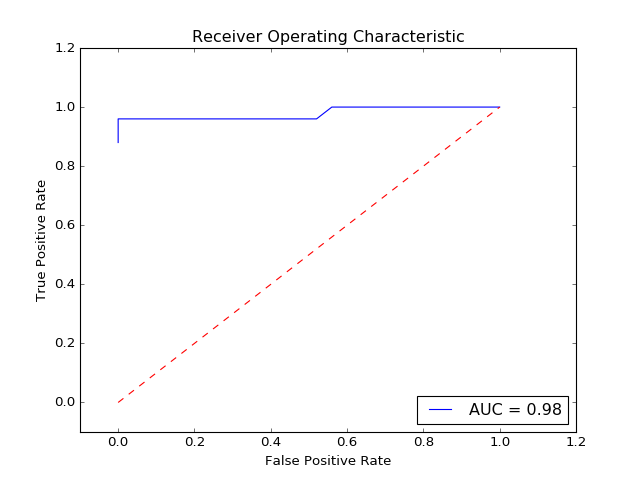

In [48]:
false_positive_rate = []
true_positive_rate = []

test_report_file = open(TEST_REPORT_FILE_PATH, "w")
test_report_file.close()

print('Threshold\tSensitivity\tSpecificity')
    
for threshold in range(0, 105, 5):
    sensitivity, specificity = tb_roc(test_meta_result_match_lines, float(threshold)/100.0)
    true_positive_rate.append(sensitivity)
    false_positive_rate.append(1-specificity)
    
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()